In [93]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

In [97]:
def read_storage(filename):
	f = open(filename,)
	return json.load(f)

def storage_into_table(data):
	saveinf, saveref = [], []
	for tile in data.keys():
		inference = data[tile]["inference"]
		reference = data[tile]["reference"]
		ref_tmp = {k: v for k, v in reference.items()}
		saveref.append(pd.DataFrame(ref_tmp, index=[tile])\
					   .reset_index()\
					   .rename(columns={"index":"tile"}))
		for record in inference:
			tmp = {"tile":tile}
			for k, v in record.items():
				if k != "performance":
					tmp[k] = v
				else:
					for metric, vector in record[k].items():
						tmp[metric] = [vector]
			saveinf.append(pd.DataFrame(tmp))
	return pd.concat(saveinf), pd.concat(saveref)

def get_avg(data, metricsnames):
	for metric in metricsnames:
		data[f"avg_{metric}"] = data[metric].apply(lambda x: pd.Series(x).mean())
		data[f"std_{metric}"] = data[metric].apply(lambda x: pd.Series(x).std())
	return data

def best_combination(data, modelname, metric="avg_loss"):
	""" Return best hyperparams combination from validation data
	Args:
		data: (pd.DataFrame) validation dataframe
		modelname: (str) modelname
		metric: (str) according to which val metric combination has to be gathered
		ascending: (bool) True if metric == 'loss', False if metric in ('PSNR', 'SSIM')
	"""
	ascending = True if metric in ("avg_loss", "avg_mae", "avg_mse") else False
	combination = (data[data["modelname"] == modelname]\
		.sort_values(by = metric, ascending=ascending)\
		.iloc[0][["modelname", "crop_size", "niterations", "nitems", "npairs"]]\
		.tolist())
	# Correct datatype to be json serializable
	for i, _ in enumerate(combination):
		try: combination[i] = int(combination[i])
		except: pass
	# from str to list
	combination[-1] = [
		   int(item) for item in combination[-1].replace("[","").replace("]","").split(",")]
	return combination


In [204]:
# Read validation storage
filename_validation = "storage_validation.json"
modelnames = ["zssrnet", "zssrnet_hf", "mrunet", "mrunet_hf", "hfgnet_s"]
metrics    = ["loss","mae","mse","psnr","ssim","bias"]
dfvalidation, _ = storage_into_table(read_storage(filename_validation))
dfvalidation    = get_avg(dfvalidation, metrics)

# Read full data storage
filename_storage = "storage.json"
df, ref = storage_into_table(read_storage(filename_storage))
df = get_avg(df, metrics)

# Filter by retaining only the best performing solution
# Just for the first validation tiles.
subset = df.groupby(["tile","modelname"])["avg_loss"].min().reset_index()

tmp = [df[(df.tile==row.tile) & (df.modelname==row.modelname) & (df.avg_loss==row.avg_loss)] \
      for _, row in subset.iterrows()]

df = pd.concat(tmp)

df.head()

,tile,modelname,crop_size,niterations,nitems,npairs,loss,mae,mse,psnr,...,avg_mae,std_mae,avg_mse,std_mse,avg_psnr,std_psnr,avg_ssim,std_ssim,avg_bias,std_bias
0,AG1km.v003.45.006.0010.h5,hfgnet_s,64,5,64,"[8, 6, 4, 2]","[0.08965174853801727, 0.11379100382328033, 0.1...","[0.01106123998761177, 0.031200604513287544, 0....","[0.00021770966122858226, 0.0011262858752161264...","[36.62122344970703, 29.48351287841797, 35.9308...",...,0.012581,0.005404,0.000288,0.000239,36.069270,2.081640,0.909479,0.012626,-0.007061,0.007407
0,AG1km.v003.45.006.0010.h5,mrunet,64,1,256,"[8, 6, 4, 2]","[0.2405988574028015, 0.20639890432357788, 0.11...","[0.09472305327653885, 0.10617136210203171, 0.0...","[0.009451777674257755, 0.011558289639651775, 0...","[20.24486541748047, 19.371065139770508, 28.170...",...,0.036566,0.026633,0.002267,0.003388,28.910014,4.022541,0.910940,0.018326,0.033883,0.027917
0,AG1km.v003.45.006.0010.h5,mrunet_hf,64,5,256,"[8, 6, 4, 2]","[0.13248242437839508, 0.15838377177715302, 0.1...","[0.027123168110847473, 0.027335213497281075, 0...","[0.001271261484362185, 0.0011558497790247202, ...","[28.957651138305664, 29.370986938476562, 32.16...",...,0.022342,0.002351,0.000721,0.000209,31.554571,1.044313,0.897790,0.010804,0.018030,0.003582
0,AG1km.v003.45.006.0010.h5,zssrnet,64,5,64,"[8, 7]","[0.10734200477600098, 0.10194749385118484, 0.1...","[0.030212758108973503, 0.024985143914818764, 0...","[0.0010532770538702607, 0.0007553663454018533,...","[29.774572372436523, 31.21842384338379, 30.384...",...,0.028376,0.001416,0.000944,0.000081,30.264465,0.387632,0.922936,0.000044,0.027992,0.001483
0,AG1km.v003.45.006.0010.h5,zssrnet_hf,64,5,64,"[8, 7]","[0.08591444045305252, 0.08688507974147797, 0.0...","[0.009287722408771515, 0.01024441234767437, 0....","[0.00016043795039877295, 0.0001877502509159967...","[37.946929931640625, 37.26419448852539, 37.435...",...,0.011802,0.003481,0.000245,0.000130,36.457452,1.629158,0.922657,0.000967,-0.006585,0.006042


In [196]:
def plot_over_tiles(outfile, df, ref, metric, ylims, thr_value=None):
    _, axs = plt.subplots(3, 6, figsize=(20,10))
    axs = axs.flatten()
    for i,tile in enumerate(df.tile.unique()):
        ref_value = ref[(ref.tile==tile)][metric].values[0]
        sub = df[df.tile==tile]
        modelnms = sub.modelname.unique().tolist()
        split = tile.split(".")
        titlename = " ".join([split[0], split[2], split[3]])
        axs[i].boxplot(sub[metric][0])
        axs[i].set_title(titlename, fontsize=12)
        axs[i].set_ylim(ylims)
        axs[i].hlines(ref_value, 0.5, 5.5, linestyle="dashed")
        if thr_value:
            axs[i].hlines(thr_value, 0.5, 5.5, color="grey", linestyle="dashed")
        axs[i].grid(alpha=0.4)
        if i > 12:
            axs[i].set_xticks(range(1,6), modelnms, rotation=90)
        else:
            axs[i].set_xticks([])

    plt.suptitle(metric, fontsize=18)
    plt.tight_layout()
    plt.savefig(outfile)
    plt.show()

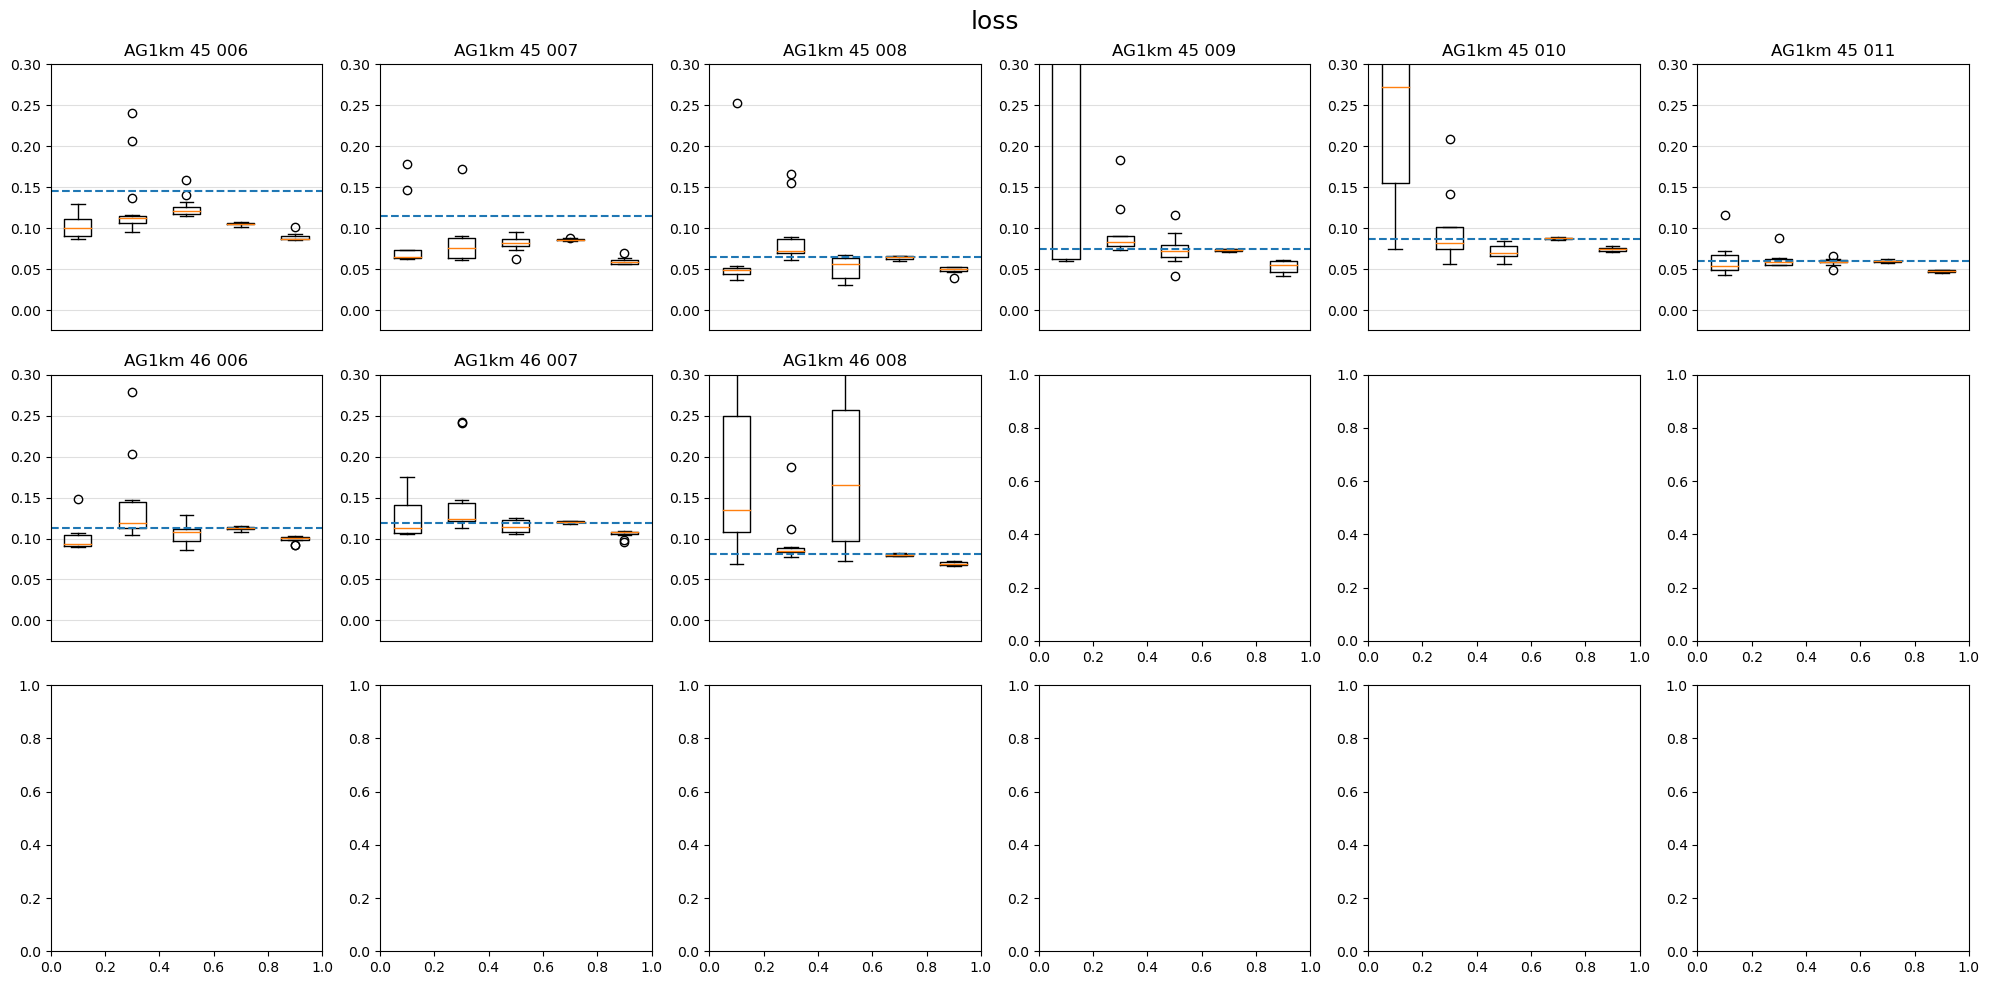

In [197]:
outfile = "across_tiles_loss.jpg"
ylims = (-0.025, 0.3)
thr_value = (0.0)
plot_over_tiles(outfile, df, ref, "loss", ylims, thr_value)

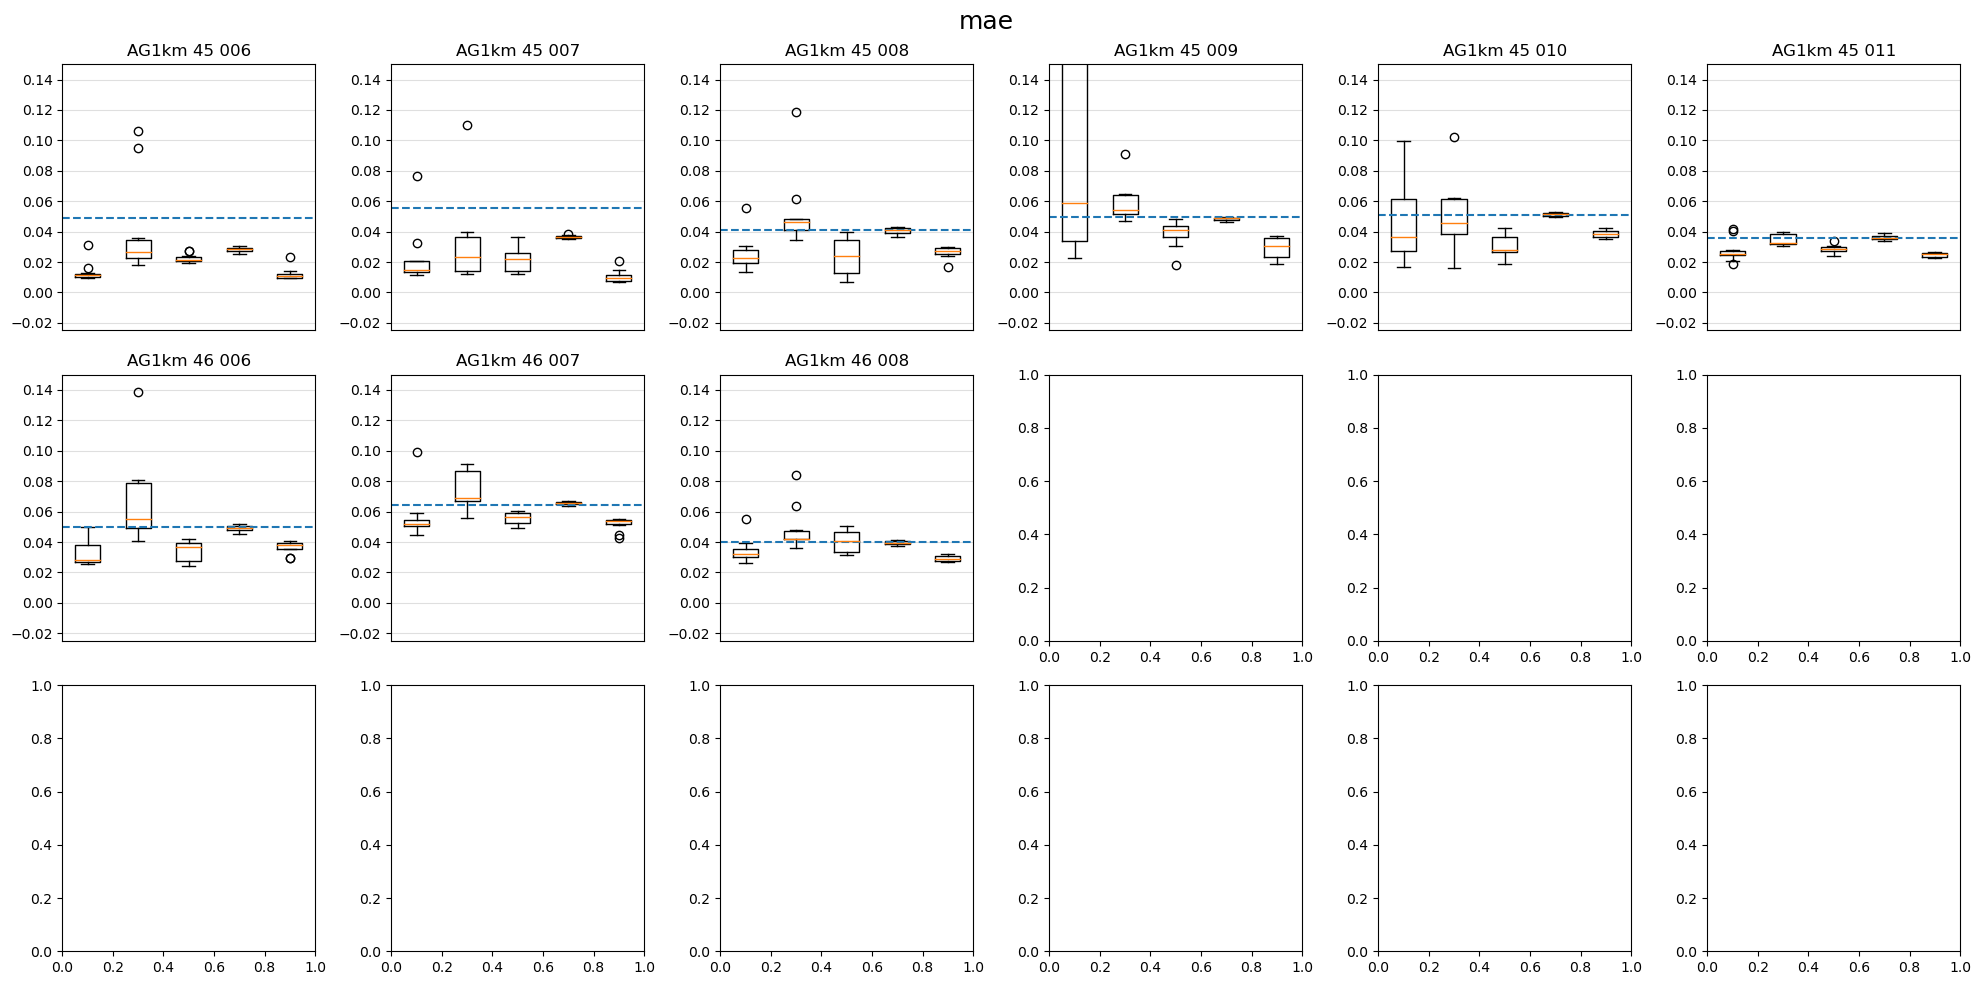

In [198]:
outfile = "across_tiles_mae.jpg"
ylims = (-0.025, 0.15)
thr_value = (0.0) 
plot_over_tiles(outfile, df, ref, "mae", ylims, thr_value)

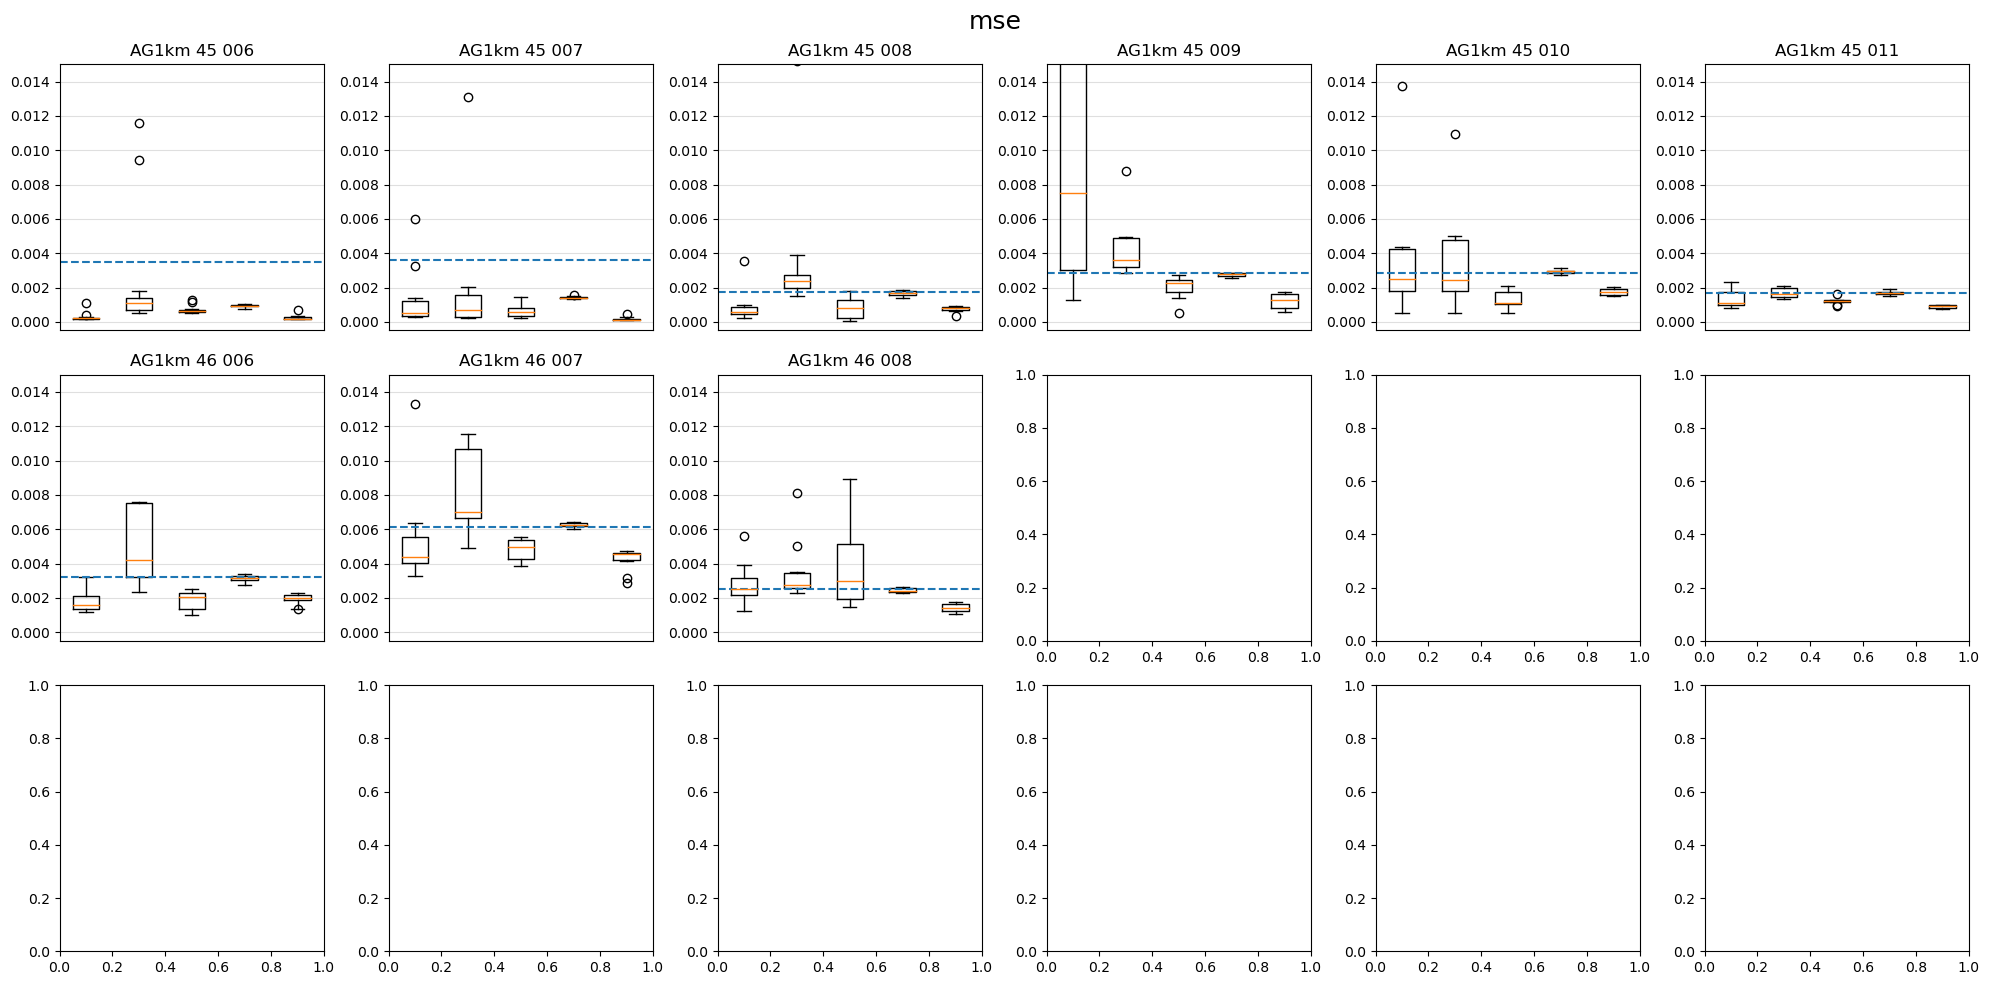

In [199]:
outfile = "across_tiles_mse.jpg"
ylims = (-0.0005, 0.015)
thr_value = (0.0)
plot_over_tiles(outfile, df, ref, "mse", ylims, thr_value)

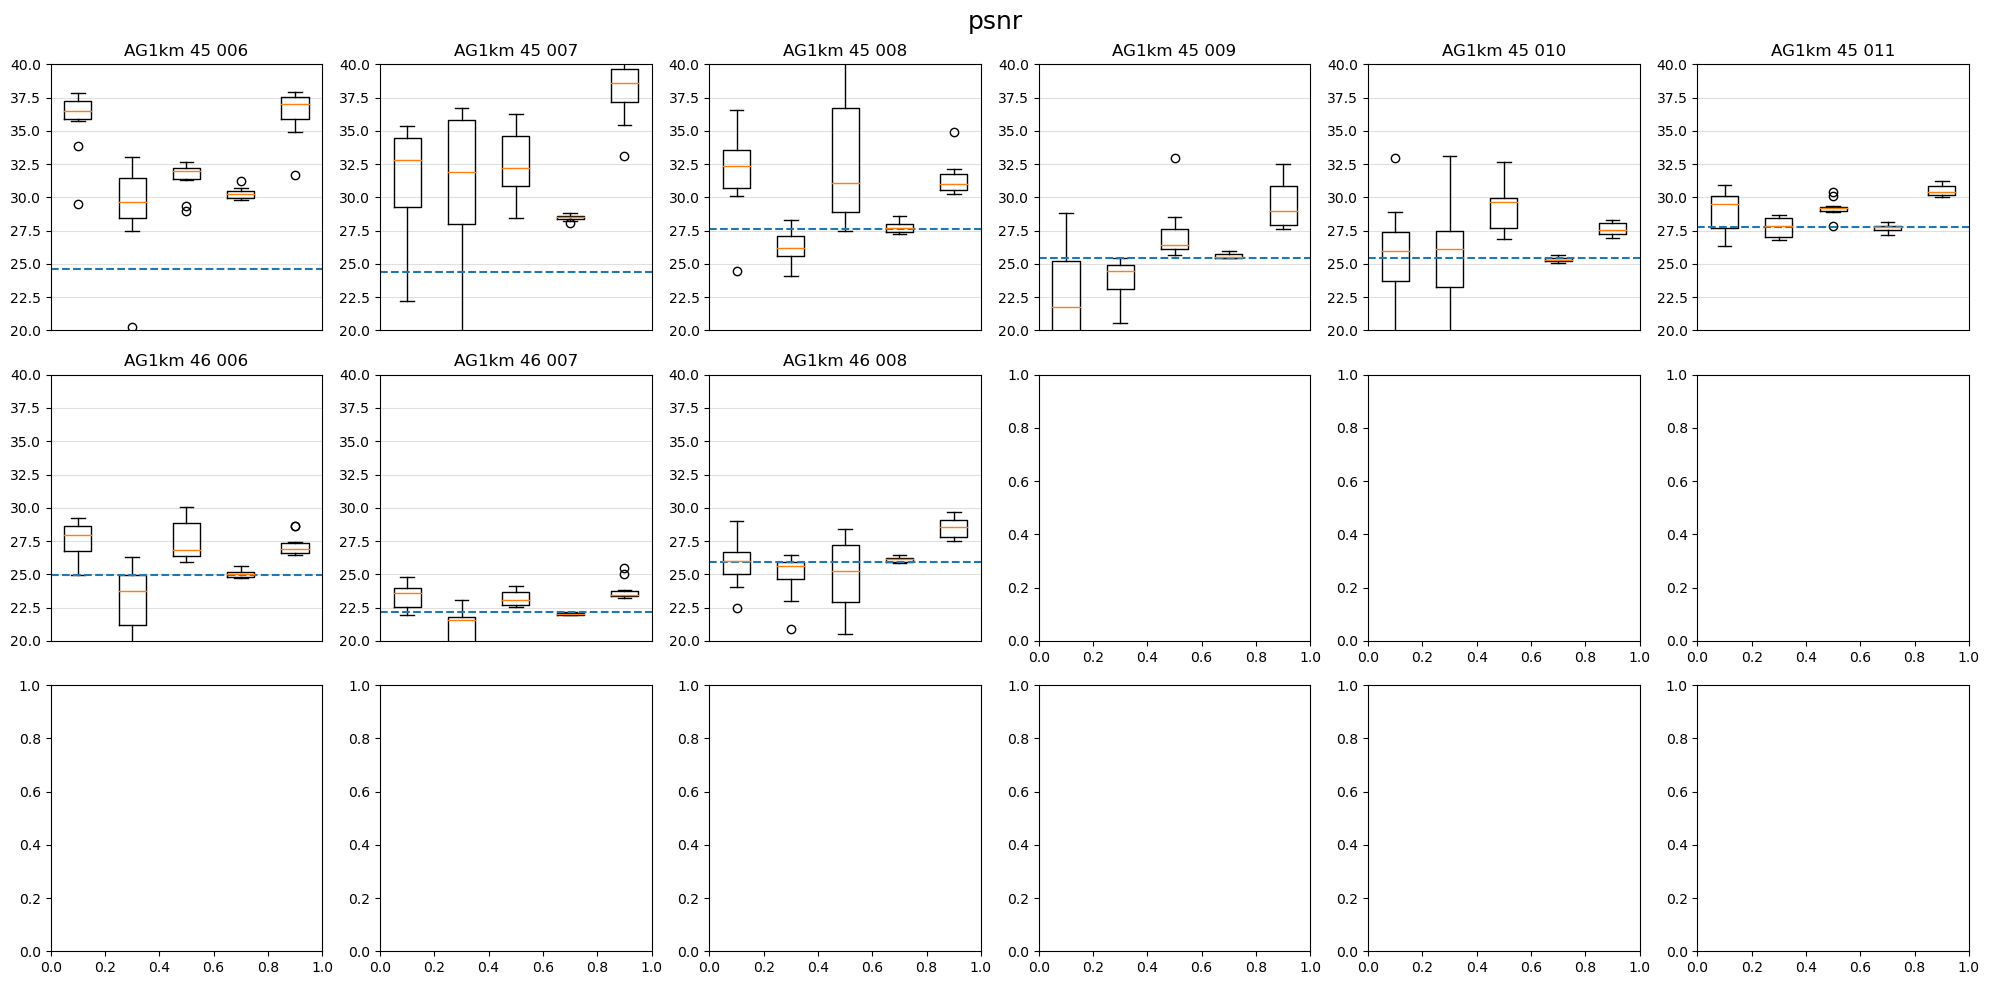

In [200]:
outfile = "across_tiles_psnr.jpg"
ylims = (20, 40)
plot_over_tiles(outfile, df, ref, "psnr", ylims, thr_value=None)

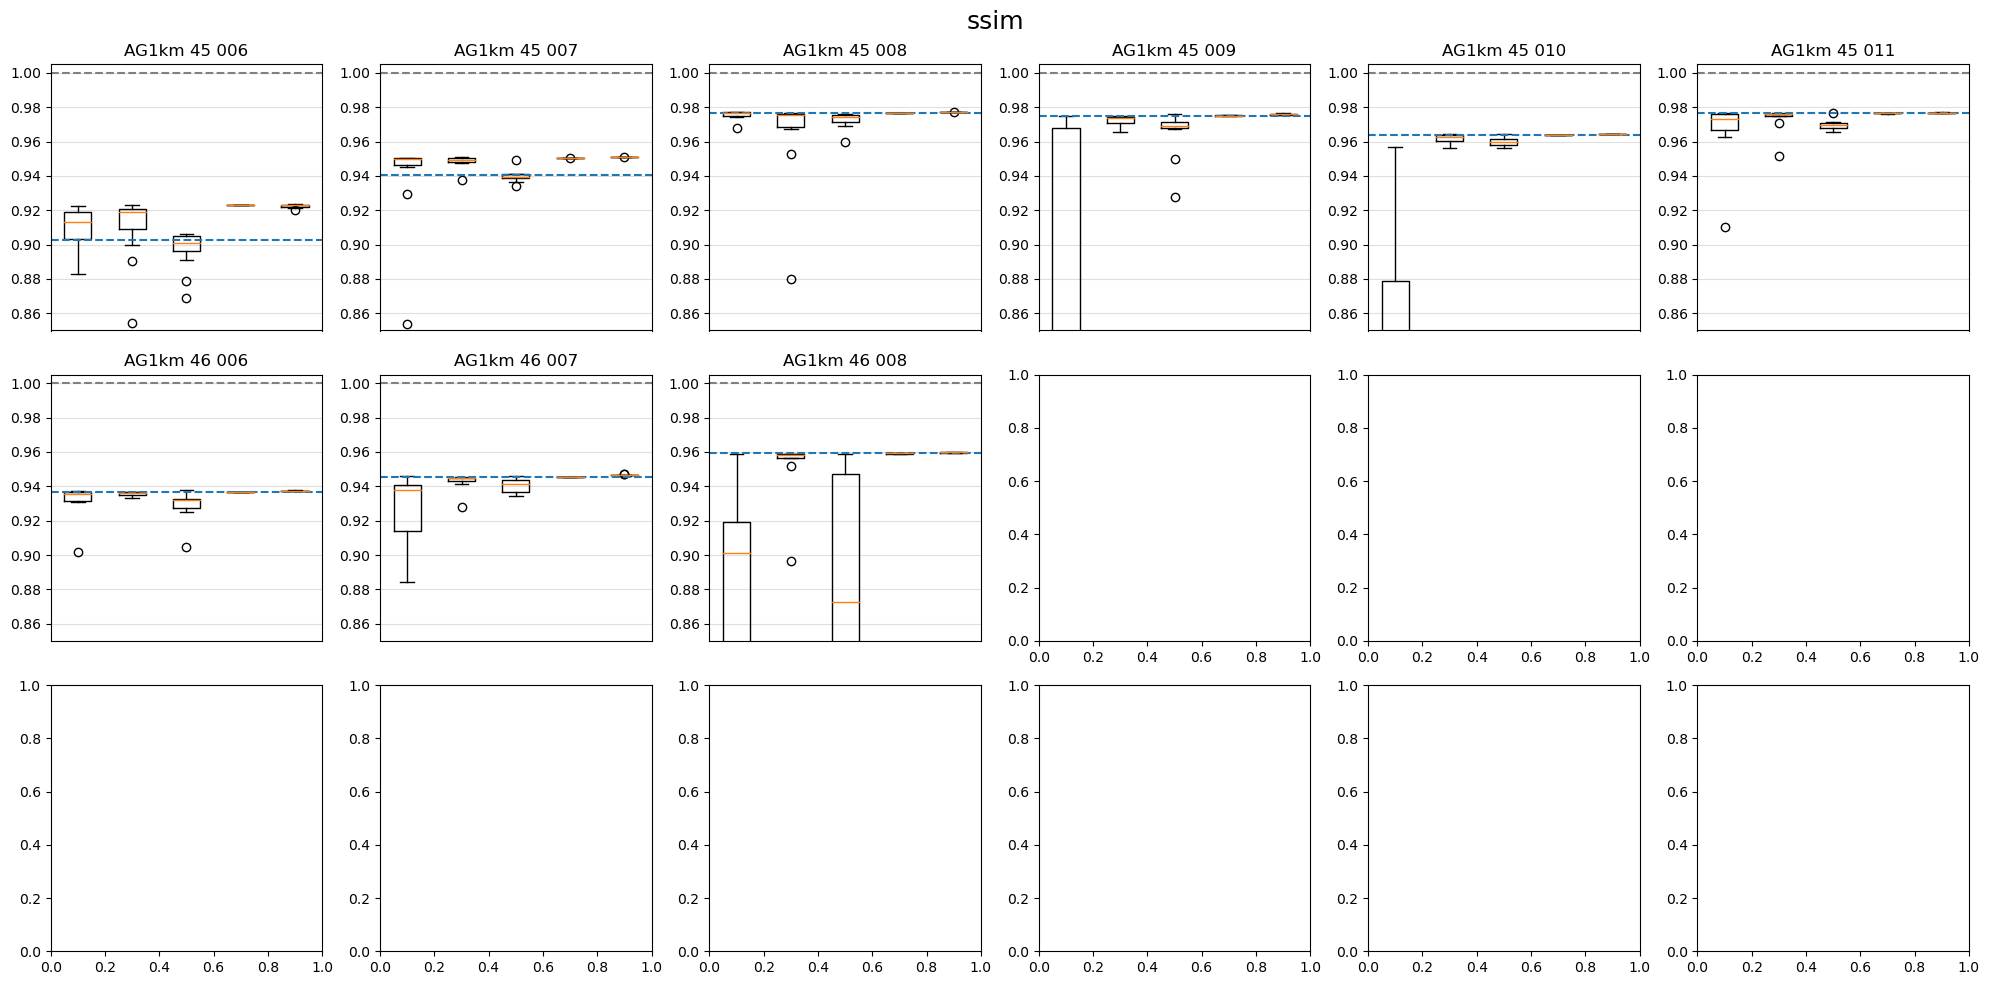

In [202]:
outfile = "across_tiles_ssim.jpg"
ylims = (0.85, 1.005)
thr_value = (1.0)
plot_over_tiles(outfile, df, ref, "ssim", ylims, thr_value)

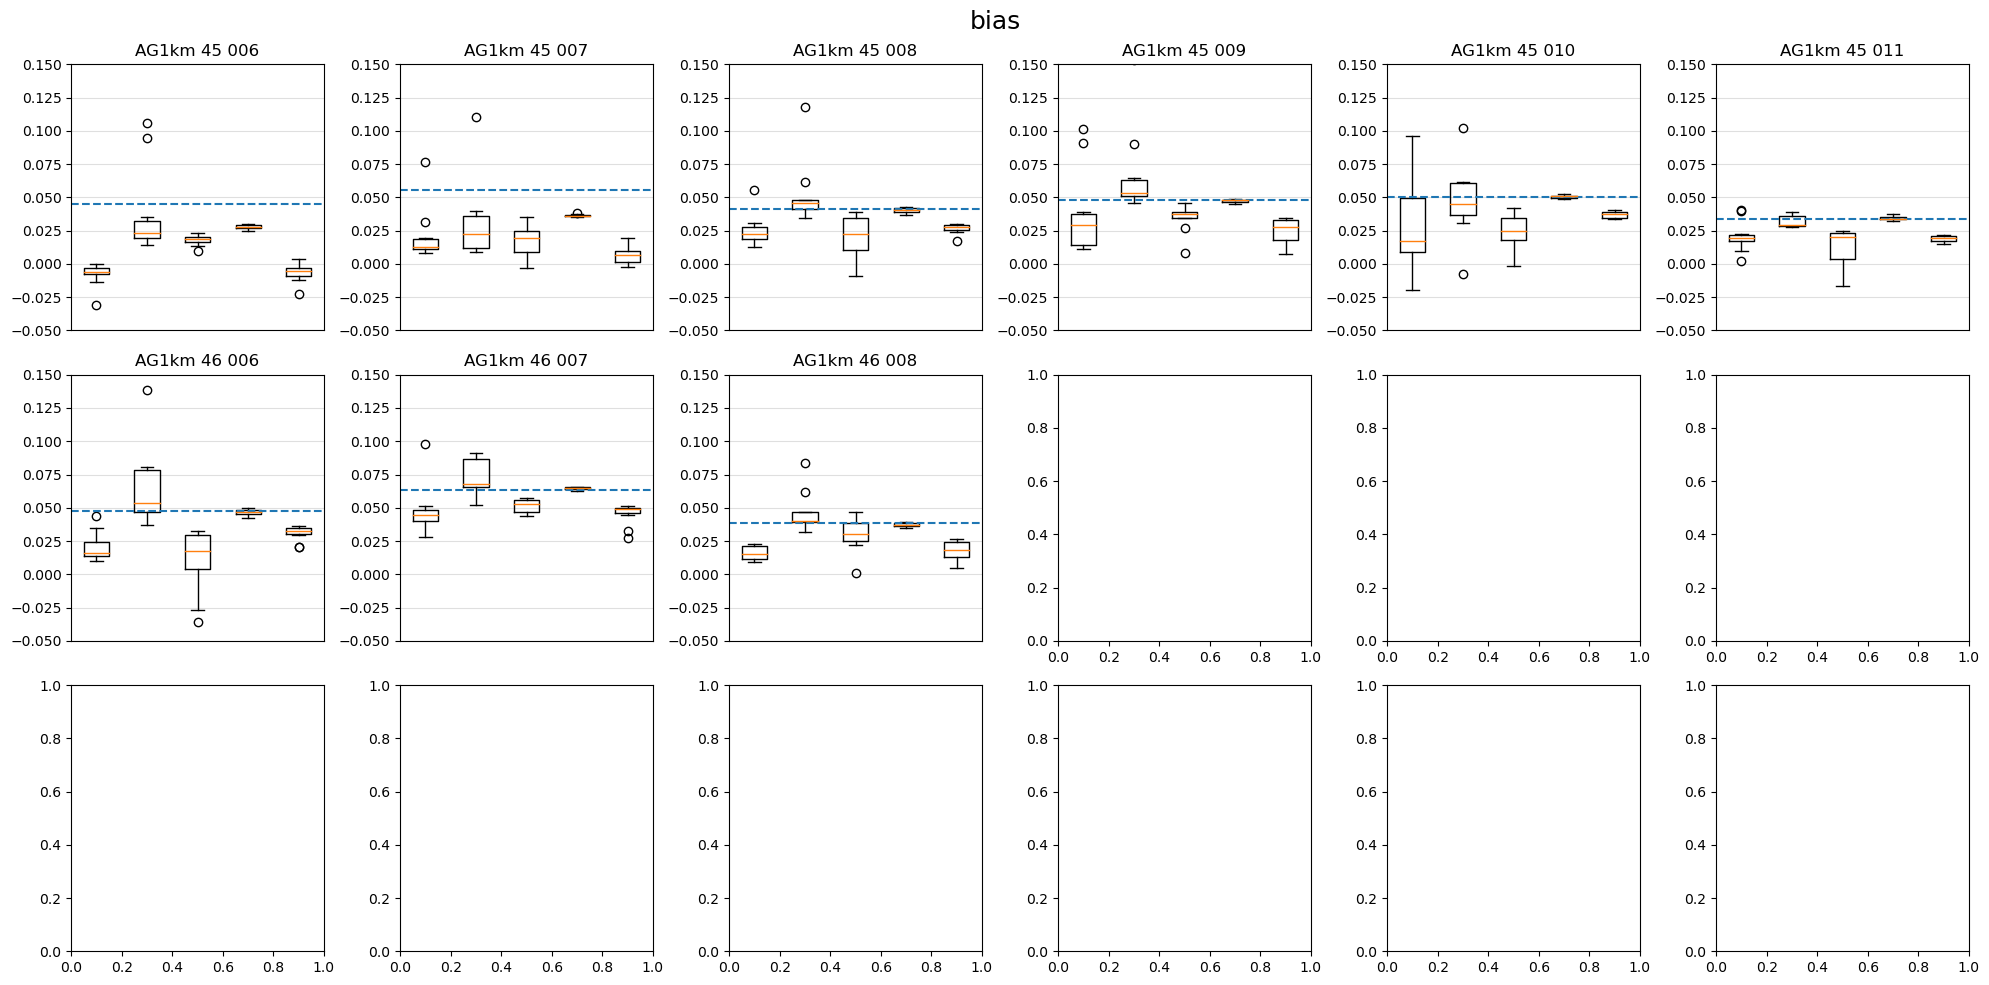

In [203]:
outfile = "across_tiles_bias.jpg"
ylims = (-0.05, 0.15)
thr_value = (0.0)
plot_over_tiles(outfile, df, ref, "bias", ylims, thr_value)